### Data Here
--- 

In [3]:
import pyarrow.parquet as pa
import pandas as pd
import numpy as np
from ipywidgets import AppLayout, GridspecLayout, Button, Label, Layout, HTML
from IPython.display import display, clear_output, update_display
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.graph_objects as go


In [4]:
table = pa.read_table("Midjourney2023_Upscale.parquet")
df = table.to_pandas()  

In [5]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df = df.sort_values(by="timestamp")
df["date"] = df["timestamp"].dt.date
datesToRemove = ["2023-10-24", "2023-11-01"]
datesToRemove = pd.to_datetime(datesToRemove).date
promptDF = df[~df["date"].isin(datesToRemove)]

In [6]:
promptDF = promptDF.drop(columns=["image_url"])

In [7]:
promptDF["timestamp"] = pd.to_datetime(promptDF["timestamp"])
first_timestamp = promptDF["timestamp"].min()
last_timestamp = promptDF["timestamp"].max()

In [8]:
imageRefs = promptDF["prompt"].str.extractall(r'\<(https://s\.mj\.run/[^\>]+)\>').reset_index()
imageRefs.columns = ["index", "match", "url"]

In [9]:
#Removing the image refs and putting the url-less prompt in a new column
promptDF["prompt_part"] = promptDF["prompt"].replace(r'\<https://s\.mj\.run/[^\>]+\>', '', regex=True)

In [10]:
#Oh my god nevermind I wish it was that easy.
#Regex = regular expression = rational expression. It's a sequence of characters that specifies a match pattern in text
#This one is looking for a space, a variety of dash types that Midjourney accepts and makes sure they're not followed by a 
#space or digit. It then looks for alphabetical characters followed by a space and optionally one or more digits
# and then there's a word boundary I don't wholly understand 
params_regex = r"((?:\s(?:—|--|–-|––)(?!\s|\d)[a-zA-Z]+(?: \d+)?\b.*))"
params = promptDF['prompt'].str.extractall(params_regex)

params.reset_index(inplace=True)
uniqueParams = params[0].unique()

In [11]:
#What prompt has the most number of image reference urls?
imageRefCounts = imageRefs["index"].value_counts()
maxRefIndex = imageRefCounts.idxmax()
maxRefCount = imageRefCounts.max()

In [12]:
#How many prompts are running image reference only?
promptDF["hasImageRef"] = promptDF.index.isin(imageRefs["index"])
imageOnlyPrompts = promptDF[(promptDF["prompt_part"] == '') & (promptDF["hasImageRef"])]

#Hmm. 1 doesn't seem right at all. Not everyone is aware of "image blending" but it's not -that- rare.
# Filter to find entries with only non-printable or special characters
filteredNonPrintable = promptDF[promptDF["prompt_part"].str.match(r'^[\s]*$') & promptDF["hasImageRef"]]

In [13]:
#As per the robot's suggestion, further cleaning the prompt part data. Also TIL "lambda" is basically like a JS arrow function.
promptDF["prompt_part"] = promptDF["prompt_part"].apply(lambda x: " ".join(x.split()))

import string

printable = set(string.printable)
promptDF["prompt_part"] = promptDF["prompt_part"].apply(lambda x: ''.join(filter(lambda y: y in printable, x)))

#Make empty cells nan
promptDF["prompt_part"] = promptDF["prompt_part"].apply(lambda x: x.strip() if x.strip() else np.nan)

In [14]:
#How many prompts are running image reference only? #2
promptDF["hasImageRef"] = promptDF.index.isin(imageRefs["index"])
imageOnlyPrompts = promptDF[(promptDF["prompt_part"].isna() | (promptDF["prompt_part"] == '')) & promptDF["hasImageRef"]]
numImageOnlyPrompts = imageOnlyPrompts["prompt"].count()
print(f"Number of prompts with only image references: {numImageOnlyPrompts}")

Number of prompts with only image references: 20088


In [15]:
totalPrompts = promptDF["prompt"].count()
uniquePrompts = promptDF["prompt"].unique()
numUniquePrompts = len(uniquePrompts)

print(f"Total number of Prompts: {totalPrompts}")
print(f"Number of unique prompts: {numUniquePrompts}")

Total number of Prompts: 973117
Number of unique prompts: 187893


In [16]:
uniquePromptsDF = pd.DataFrame(uniquePrompts, columns=["prompt"])
uniquePromptsDF = uniquePromptsDF.merge(promptDF.drop_duplicates("prompt")[["prompt", "date"]], on="prompt", how="left")
uniquePromptsByDate = uniquePromptsDF.groupby("date").size()

In [17]:
uniqueImageOnlyPrompts = imageOnlyPrompts["prompt"].unique()
numUImagePrompts = len(uniqueImageOnlyPrompts)

print(f"Number of unique image only prompts: {numUImagePrompts}")

Number of unique image only prompts: 3891


In [18]:
repeatedPrompts = totalPrompts - numUniquePrompts

In [19]:
#obscuring user id which correlates directly to Discord id
promptDF["user_number"] = pd.factorize(promptDF["user"])[0] + 1  # Adding 1 to start numbering from 1 instead of 0

In [20]:
uniqueUsers = promptDF["user"].nunique()
uniqueUsers

24485

In [21]:
promptsPerUser = promptDF["user"].value_counts()

In [22]:
uniquePromptsPerUser = promptDF.groupby("user")["prompt"].nunique()

In [32]:
averageUniquePrompts = uniquePromptsPerUser.mean()
maxUniquePrompts = uniquePromptsPerUser.max()
minUniquePrompts = uniquePromptsPerUser.min()

print("Average number of unique prompts per user:", averageUniquePrompts)
print("Most prompts by a single user:", maxUniquePrompts)
print("Minimum number of unique prompts by a single user:", minUniquePrompts)

Average number of unique prompts per user: 7.848274453747192
Most prompts by a single user: 991
Minimum number of unique prompts by a single user: 1


In [24]:
comparisonDF = pd.DataFrame({
    "Total Prompts": promptsPerUser,
    "Unique Prompts": uniquePromptsPerUser})

In [25]:
dailyActivity = promptDF.groupby(["user", "date"]).size().reset_index(name="counts")

In [26]:
totalDays = promptDF["date"].nunique()
uniqueDays = promptDF["date"].unique()
dailyPrompts = promptDF.groupby("date").size()

In [27]:
userActiveDays = dailyActivity.groupby("user")["date"].nunique()

In [28]:
activeEveryDayUsers = userActiveDays[userActiveDays == totalDays]
countUsersActiveEveryDay = activeEveryDayUsers.count()
countUsersActiveEveryDay
print(f"Number of users that prompted every tracked day: {countUsersActiveEveryDay}")

Number of users that prompted every tracked day: 11


In [29]:
promptFrequencies = promptDF["prompt"].value_counts()
averageFrequency = promptFrequencies.mean()
medianFrequency = promptFrequencies.median()

mostFrequentPrompt = promptFrequencies.idxmax()
mostFrequentCount = promptFrequencies.max()

### Functions Here
---

In [33]:
def totalPromptGraph():
    fig = go.Figure()
    
    fig.add_trace(go.Bar(
        x=dailyPrompts.index,  
        y=dailyPrompts.values,
        name="Total Prompts Posted Each Day",
        marker=dict(color='rgb(151,166,196)')
    ))
    
    fig.update_layout(
        title=f"Over Thirteen Days {totalPrompts:,} Prompts were Successfully Generated by {uniqueUsers:,} Users",
        
        #xaxis_title="2023",
        autosize=False,
        width=900,
        height=600,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=6
        ),
    hoverlabel=dict(
            bgcolor="white", 
            font_size=15, 
        )
    )
    
    fig.update_xaxes(showgrid=False, tickvals=dailyPrompts.index, tickformat="%m-%d")
    fig.update_yaxes(showgrid=False)
    #fig.update_layout(template="simple_white")
    
    fig.show()

In [36]:
def totalPromptOverlay():
    fig2 = go.Figure()
    
    fig2.add_trace(go.Bar(
        x=dailyPrompts.index,  
        y=dailyPrompts.values,
        name="Total Daily Prompts",
        marker=dict(color="rgb(56,72,96)")
    ))
    
    
    fig2.add_trace(go.Bar(
        x=uniquePromptsByDate.index,  
        y=uniquePromptsByDate.values,
        name="Total Unique Daily Prompts",
        marker=dict(color="rgb(151,166,196)")
    ))
    
    fig2.update_layout(
        title=f"Of Those {totalPrompts:,} Prompts, {numUniquePrompts:,} were Unique",
        autosize=False,
        width=900,
        height=600,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=6
        ),
        hoverlabel=dict(
            bgcolor="white", 
            font_size=15, 
        ),
        barmode="overlay",
        legend=dict(
            yanchor="top",
            y=-0.2,
            xanchor="center",
            x=0.5
        )
    )
    
    fig2.update_xaxes(showgrid=False, tickvals=dailyPrompts.index, tickformat="%m-%d")
    fig2.update_yaxes(showgrid=False)
    
    fig2.show()

In [34]:
def percentUniqueGraph():

    fig4 = go.Figure(data=[go.Pie(
        labels=["Total Prompts", "Unique Prompts"],
        values=[totalPrompts, numUniquePrompts],
        pull=[0, 0.2],
        marker=dict(colors=["rgb(151,166,196)", "orange"])
    )])
    
    fig4.update_layout(
        title="That's Only 16.2%",
        autosize=False,
        width=500,
        height=500,
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4
        )
    )
   
    fig4.show()

![title image](/Data Interaction/mjtitle.png)

# Is Generating AI Imagery with Midjourney "Easy"?
---
### Or, better stated, how much repetition is there in image prompting?


Ease is a subjective question for sure, especially without direct user input. Nonetheless, we're going to take a look at some user activity to see what information can be gleaned from that.


The [dataset](https://bridges.monash.edu/articles/dataset/Midjourney_2023_Dataset/25038404) used is from Monash University and spans 10/24/23-11/9/23. A dataset retrospective can be found at the bottom.

## Let's Take a Look at Prompt Data from 10/24/23 - 11/9/23 
---
*Data gaps likely from Discord API Outages

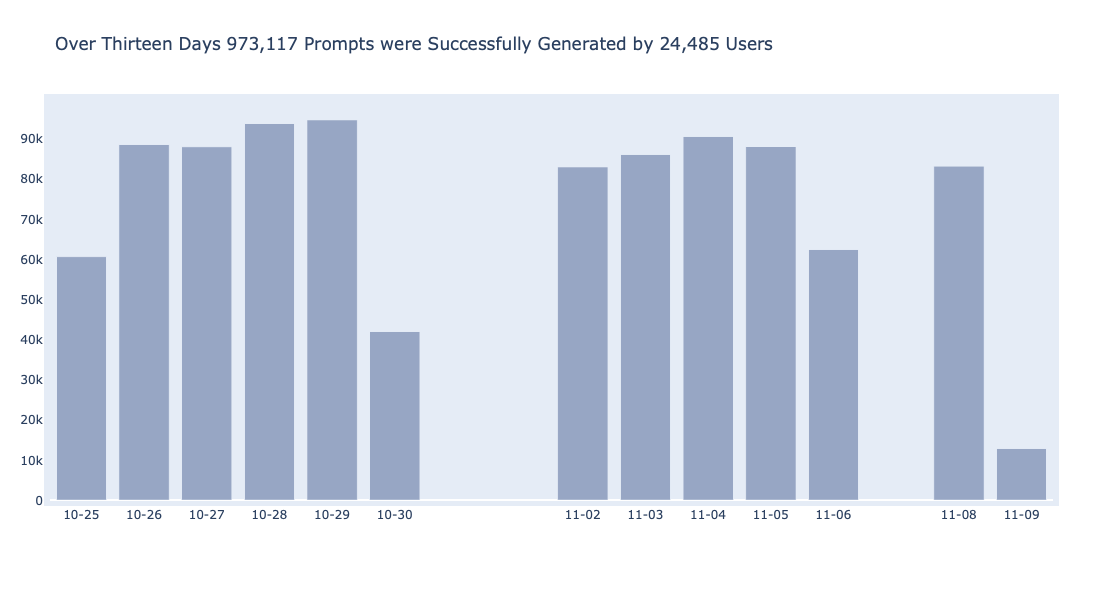

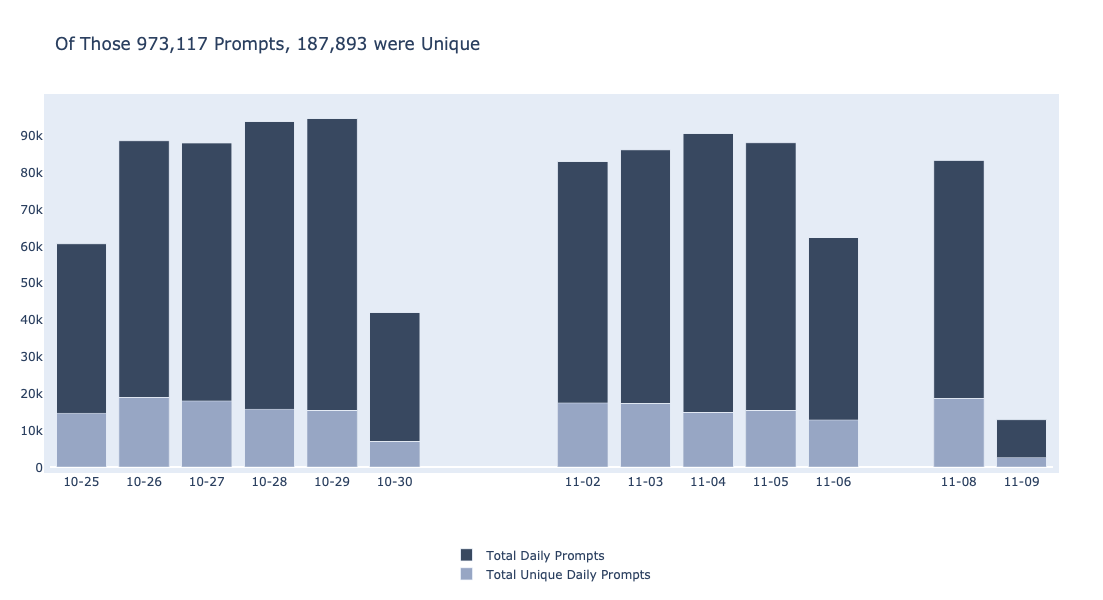

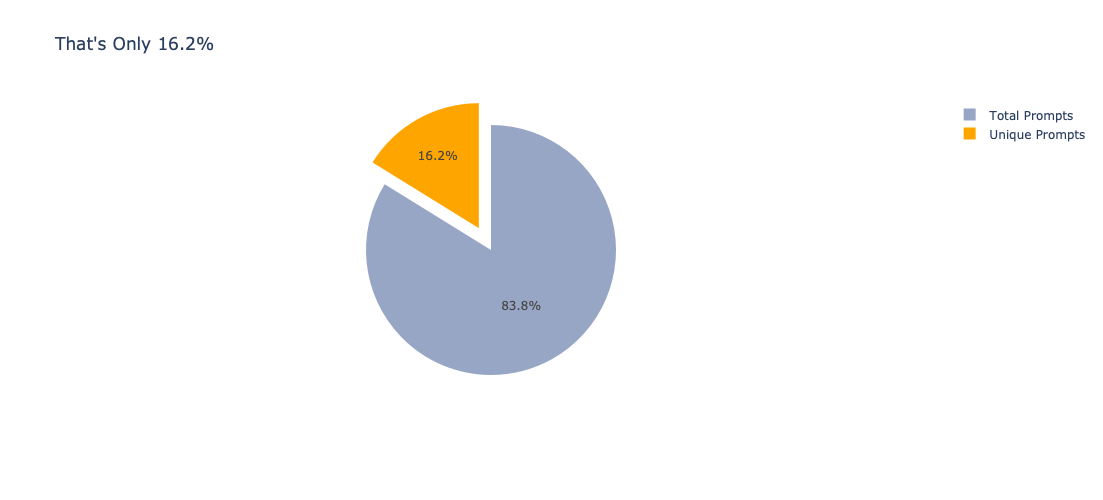

In [37]:
totalPromptGraph()
totalPromptOverlay()
percentUniqueGraph()

#### So what are users doing?
---


Across the tracked timespan, on average, users posted **40** prompts, with **8** being unique. 




**The most frequently appearing prompt is:** "Morticia Addams as a soaking wet vampire with fangs, laughing, getting doused with water, completely soaked, wet black hair slicked down flat, under a waterfall in a cave, glamorous black gown, vampire, red eyes, fangs, cute, 3D, pouring rain, thunderstorm  " appearing **1487** times.


- **2** ":beautiful model face composed by a three dimensional, minimal, abstract sculpture in the style of giacomo balla and umberto boccioni inspired by catholic virgen iconography . mixed fake religions iconography. italian XXII monumental architecture. clean + modern + fractal + e8 lattice + rough+ graffuturism" appearing **1136** times.

- **3** "Gold, Blond hair korean young women, Happy, Pretty, Cutie" appearing **1016** times. 


- **4** "face of woman with short blonde hair in a pale pink dress frozen in a huge block of ice, polar scenery, cold, ultra realistic photographic style - Laica lens - upbeta - v 5.2"  appearing **749** times.


- **5** "gorgeous Atlantis Kingdom Pacific Rim mech Hinduism Creature Fakemon Ganesha, leoiruga art, albrt wlson art, lunaurum art, full head, full body, white background" appearing **623** times.

---

For the rest, a unique prompt was repeated on average **5 times.**

## Random Prompt Viewer
---

In [60]:
promptLabel = HTML()

def showRandomPrompt():
    randomPrompt = np.random.choice(uniquePrompts)  
    promptLabel.value = f'<pre>{randomPrompt}</pre>'

button = Button(description=" Show Random Prompt", layout=Layout(width="auto"), icon="lightbulb", button_style="primary")

# Event handler for the button's on_click event
def onButtonClicked(b):
    showRandomPrompt()
    
linebreaks = HTML("<br><br>")
display(linebreaks)

button.on_click(onButtonClicked)
display(button)
display(promptLabel)
showRandomPrompt()

HTML(value='<br><br>')

Button(button_style='primary', description=' Show Random Prompt', icon='lightbulb', layout=Layout(width='auto'…

HTML(value='')

## Further In Progress Observations
---

Average prompt length with reference image urls and parameters filtered out?
Is there any correlation between length of prompt and how many frequently it is repeated?

Is there any correlation between misused parameters and frequency of repeats?

Did anyone continue repeating prompts after a period of 24 hours?
All sorts of time related questions.
1d heat map of prompt frequency over 24 hour periods.

## Dataset Retrospective
---

As a heavy Midjourney user myself, this dataset is fairly nice and clean right off the bat. 

The dataset came set up as, as worded by the original authors:

**prompt** - the user written prompt

**user** - a numeric id for each user

**timestamp** - the date & time the prompt was entered

**image_url** - the URL of the image generated from the prompt


### The Good
---
- The image reference links are included in the prompts.
- This would be a nice dataset for using a Natural Language Processor and looking at the 'tone' of the various prompts.
- Nice for looking at users using [parameters](https://docs.midjourney.com/docs/parameter-list) incorrectly.
- Can observe prompt length so long as you remove image reference links and (properly) remove parameters.

### The Bad
---
- The dataset lacks really useful information like whether the image was broken out of a quad (Image #1, Image #2, Image #3, Image #4), if it was remixed, rerolled, had region variation. This portion of the prompt was completely left out of the data.
- There are 4 days out of the total that were completely missing or had literally a handful of data (less tha 20 prompts). This is likely due to Discord API outages, but it's still unfortunate. 
- The website for the dataset states "The upscale dataset contains prompts that were selected for upscaling only." but I saw no such upscale dataset anywhere.
- While the prompts all include urls to the rendered image, but due to Discord having implemented security measures for their links using their service, they expire after about 24 hours. Hoever, they still can be viewed if the links are pasted in Discord itself.
- Since the prompts lack the information about whether they were remixed and so on, it's possible that some of the parameters on the prompts got cut off

### The 'I'm Really Picky About this Wording'
---
- The timestamp actually isn't the time the prompt was entered, it's the time the prompt was *returned* by the Midjourney bot.
- The dataset has all successfully returned prompts; it doesn't include error data or rejected prompts (which are viewable only to the user whose prompt was rejected).
- The "numeric id" for each user is actually their Discord ID number.
- This dataset doesn't include *all* the prompts from the datespan, nor would I expect it to. But someone less familiar with Midjourney might not know that users can prompt in places other than the public Midjourney discord. It could be a very good sampling of data, or it could not be. Probably only the people at MJ know.
- 